Using Smopy means using OpenStreetMaps.  Per their usage rules: "Heavy use (e.g. distributing an app that uses tiles from openstreetmap.org) is forbidden without prior permission from the System Administrators. "

http://wiki.openstreetmap.org/wiki/Tile_usage_policy

In [1]:
import networkx as nx
import json
import numpy as np
import pandas as pd
import json
import smopy
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = mpl.rcParams['savefig.dpi'] = 300

## Defining the functions

In [2]:
#returns array of coordinates for any edge in the graph

def get_path(n0, n1):
    """If n0 and n1 are connected nodes in the graph, this function
    return an array of point coordinates along the road linking
    these two nodes."""
    return np.array(json.loads(g[n0][n1]['Json'])['coordinates'])

"""
    Our path contains connected nodes in the graph. 
    Every edge between two nodes is characterized by a list of points (constituting a part of the road). 
    Concatenates the positions along every edge in the path. 
"""

def get_full_path(path):
    """Return the positions along a path."""
    p_list = []
    curp = None
    for i in range(len(path)-1):
        p = get_path(path[i], path[i+1])
        if curp is None:
            curp = p
        if np.sum((p[0]-curp)**2) > np.sum((p[-1]-curp)**2):
            p = p[::-1,:]
        p_list.append(p)
        curp = p[-1]
    return np.vstack(p_list)

In [3]:
#plot nodes, a function sometimes called in plt_edge
def plt_node(a,b, color='black', size=1):
    
    for x,y in zip(a,b):
        ax.plot(x,y, 'o', color=color, ms=size, markeredgewidth=0.0)
        
#given a path and color, plot it.  Optional: plot nodes, adjust width
def plt_edge(mini_path, color, plot_nodes=False, width=0.5):
    mini_linepath = get_full_path(mini_path)
    mx, my = map.to_pixels(mini_linepath[:,1], mini_linepath[:,0])
    ax.plot(mx, my, '-k', lw=width, color=color, alpha=0.5)
    if plot_nodes:
        plt_node(mx, my)

We will notably use the road path to compute its length. 
We first need to define a function that computes the distance between any two points in geographical coordinates. 
This function has been found in StackOverflow. 
http://stackoverflow.com/questions/8858838/need-help-calculating-geographical-distance

In [4]:
#Now, we define a function computing a path's length.

#order of lats, lons was incorrect in tutorial! Corrected here
def get_path_length(path):
    return np.sum(geocalc(path[:-1,1], path[:-1,0], path[1:,1], path[1:,0]))

#returns in KILOMETERS
EARTH_R = 6372.8
def geocalc(lat0, lon0, lat1, lon1):
    """Return the distance (in km) between two points in 
    geographical coordinates."""
    lat0 = np.radians(lat0)
    lon0 = np.radians(lon0)
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    dlon = lon0 - lon1
    y = np.sqrt(
        (np.cos(lat1) * np.sin(dlon)) ** 2
         + (np.cos(lat0) * np.sin(lat1) 
         - np.sin(lat0) * np.cos(lat1) * np.cos(dlon)) ** 2)
    x = np.sin(lat0) * np.sin(lat1) + \
        np.cos(lat0) * np.cos(lat1) * np.cos(dlon)
    c = np.arctan2(y, x)
    return EARTH_R * c

## Prep data

Load the data (a Shapefile dataset) with NetworkX. 
This dataset contains detailed information about all roads in San Francisco County. 
NetworkX's read_shp function returns a graph, where each node is a geographical position, 
and each edge contains information about the road linking the two nodes.

In lieu of Census data, SF Gov has a full, connected graph of streets that can be found here: https://data.sfgov.org/Geographic-Locations-and-Boundaries/Streets-of-San-Francisco/4ugn-hf48

In [6]:
#build a route between two points
def build_segment(a,b):
    segment = nx.shortest_path(sg_final, 
                        source=tuple(nodes[a]), 
                        target=tuple(nodes[b]),
                        weight='distance')
    return segment[1:]

In [7]:
#given a list of coordinates, return a path

def build_path(waypoints):
    #convert waypoints to node indexes
    waypoint_nodes = [np.argmin(np.sum((nodes[:,::-1] - w)**2, axis=1)) for w in waypoints]
    
    #seed with first node
    my_path = [tuple(nodes[waypoint_nodes[0]])]
    
    #iterate thru all but last, connecting this to next
    for i in range(len(waypoints)-1):
        my_path.extend(build_segment(waypoint_nodes[i], waypoint_nodes[i+1]))
        
    return my_path

In [8]:
#given a random point and the path, what is the lower-left and upper-right map points

def find_corners(point, my_paths):
    #this finds the lowest & highest lat/lon even if not directly paired
    ll_lat = point[0]
    ll_lon = point[1]
    ur_lat = point[0]
    ur_lon = point[1]

    for mp in my_paths:
        for p in mp:
            if p[1] < ll_lat:
                ll_lat = p[1]
            if p[0] < ll_lon:
                ll_lon = p[0]
            if p[1] > ur_lat:
                ur_lat = p[1]
            if p[0] > ur_lon:
                ur_lon = p[0]

    return (ll_lat, ll_lon), (ur_lat, ur_lon)

In [5]:
g = nx.read_shp('Road files/geo_export_4d537b7d-a470-4eb9-b147-1d0ea89e6b60.shp')

#being directional means being unable to find edges unless in correct order
#so switch to unidirected
g = g.to_undirected()

sg_all = list(nx.connected_component_subgraphs(g.to_undirected()))

#grab the biggest subgraph
max_len = -1
sg_final = sg_all[0]
for sg in sg_all:
    x = len(sg)
    if x > max_len:
        max_len = x
        sg_final = sg
        
# establish all the nodes
nodes = np.array(sg_final.nodes())

In [10]:
#needed to convert csv of tuples from strings to tuples
from ast import literal_eval as make_tuple

In [9]:
#update graph by computing the distance between any two connected nodes
for n0, n1 in sg_final.edges_iter():
    path = get_path(n0, n1)
    distance = get_path_length(path)
    sg_final.edge[n0][n1]['distance'] = distance

## Build route

Load in unexplored data, use this to generate target edges to explore route possibilities

In [92]:
#load data
df = pd.read_csv('unexplored blocks.csv', sep='\t')

#for some reason, I have to explicitly state the columns or it bugs out
df.columns = ['start', 'end']

#iterate through csv of unrun blocks, compiling into an array of edges
targets = []

for index, row in df.iterrows():
    this_target = [make_tuple(row['start']), make_tuple(row['end'])]
    targets.append(this_target)

In [94]:
#given a target edge, compile the total route and return its path & distance

def calc_route_option(my_target):
    #compile all waypoints
    my_route = [start]
    my_route.extend(my_target)
    my_route.extend([end])

    #send coordinates, receive path, add to master list
    my_path = build_path(my_route)

    #calc distance
    my_roads = pd.DataFrame([sg_final.edge[my_path[i]][my_path[i + 1]] 
                          for i in range(len(my_path) - 1)], 
                         columns=['distance', 'nhood', 'streetname'])
    
    # convert km -> mi
    my_distance = my_roads['distance'].sum() * 0.621371
    
    return my_path, my_distance

Set user-input params

In [96]:
#define a goal distance    
goal_distance = 2.25

#build up color list
colors = ['black', 'blue', 'green']

#notable spots
home = (37.790461, -122.428311)
work = (37.789006, -122.409448)

## define the key areas of the route
start = work
end = home

Run through possible routes and pick best three options

In [99]:
#for each set of targets, iterate through and build a route, calculate the distance and store in a list of routes
paths = [] 
path_distances = []

for ti in range(len(targets)):
    p,d = calc_route_option(targets[ti])
    paths.append(p)
    path_distances.append(d)


#rescore distances based on "closeness" to goal distance
distances_from_goal = [abs(i - goal_distance) for i in path_distances]

#pick closest three paths
best_paths_i = np.argsort(distances_from_goal)[:3]
best_paths = [paths[i] for i in best_paths_i]

#distances of closest three routes
for i in best_paths_i:
    print(str(round(path_distances[i],2)) + ' mi')

2.34 mi
2.43 mi
2.53 mi


Lowered zoom level to keep map size reasonable. (z = 15)


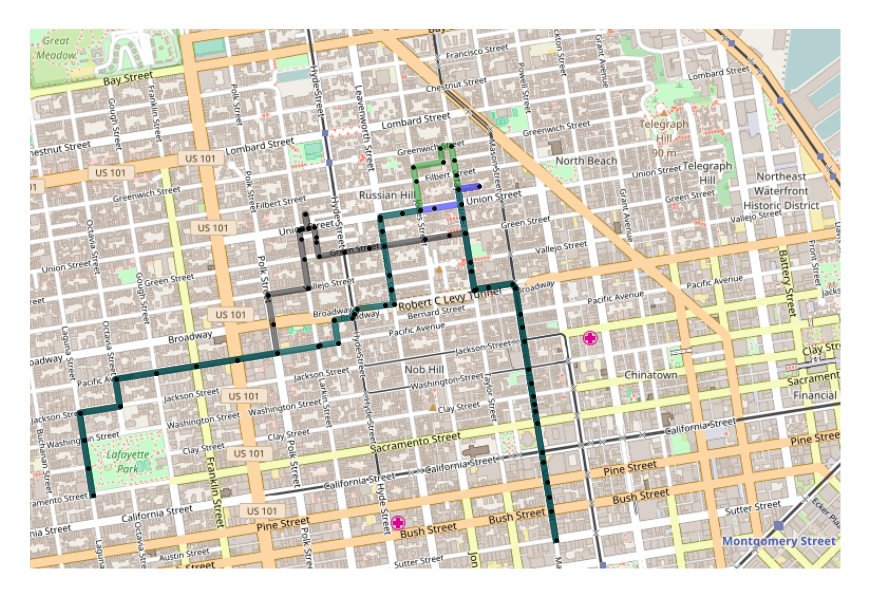

In [101]:
#display the top 3 itineraries on the map

path_ll, path_ur = find_corners(start, best_paths)

map = smopy.Map(path_ll, path_ur)

ax = map.show_mpl(figsize=(3,3))

for p_i in range(len(best_paths)):
    plt_edge(best_paths[p_i], colors[p_i], True, width=1.5)

## scratch

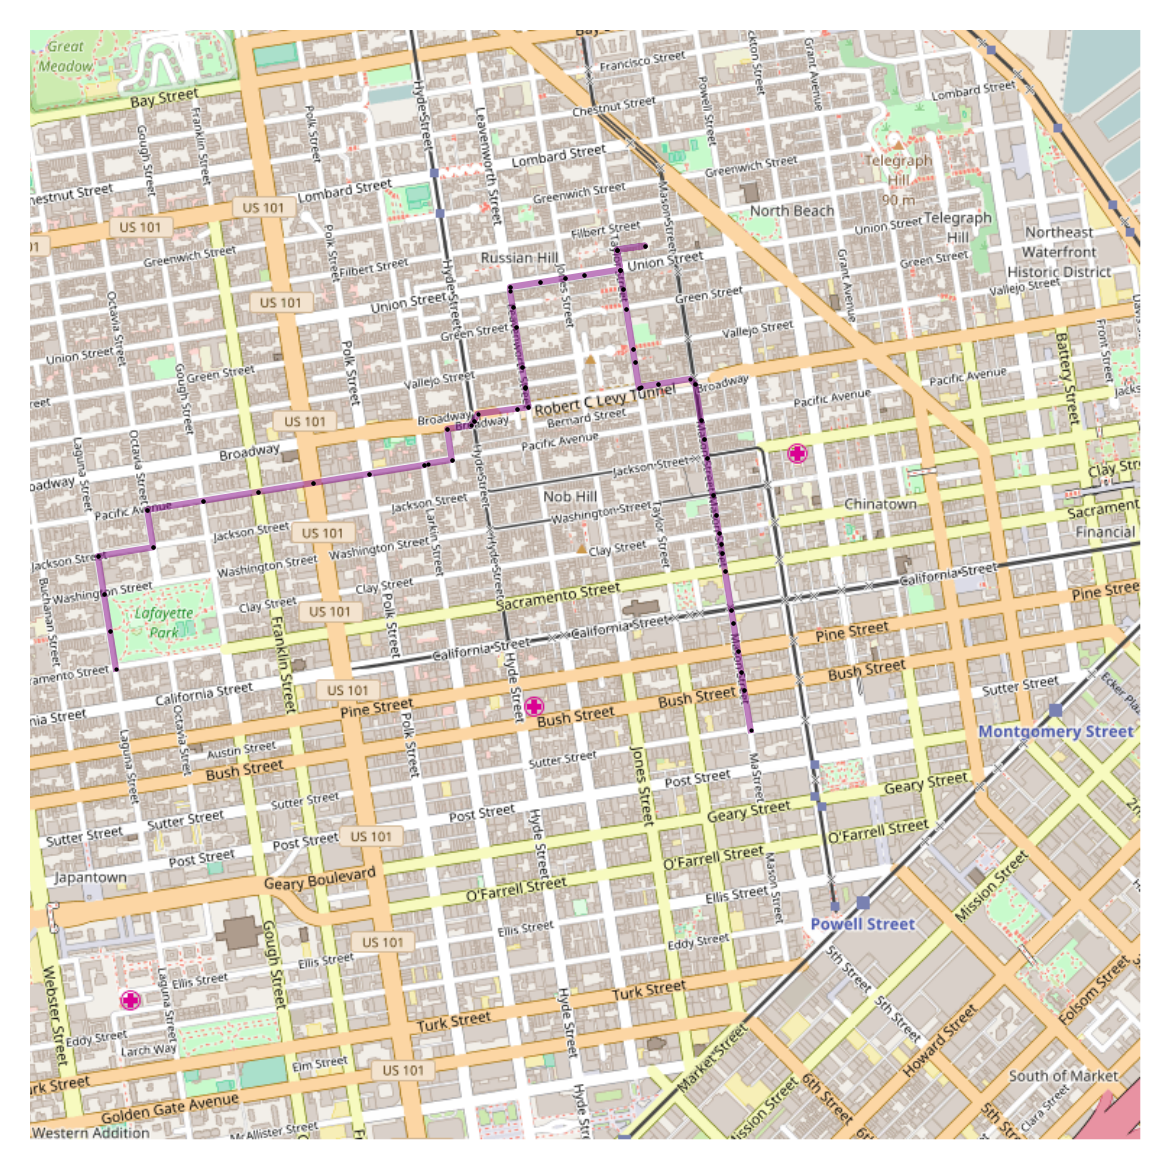

In [17]:
ax = map.show_mpl()
plt_edge(paths[3], colors[3], True, width=1.5)

In [13]:

colors = ['blue', 'red', 'green', 'purple', 'orange', 'pink', 'cyan']

[2.53, 2.43, 2.34]


In [80]:
abc = [1,2,45,6]
abc

[1, 2, 45, 6]

In [82]:
abc[4] = -1

IndexError: list assignment index out of range